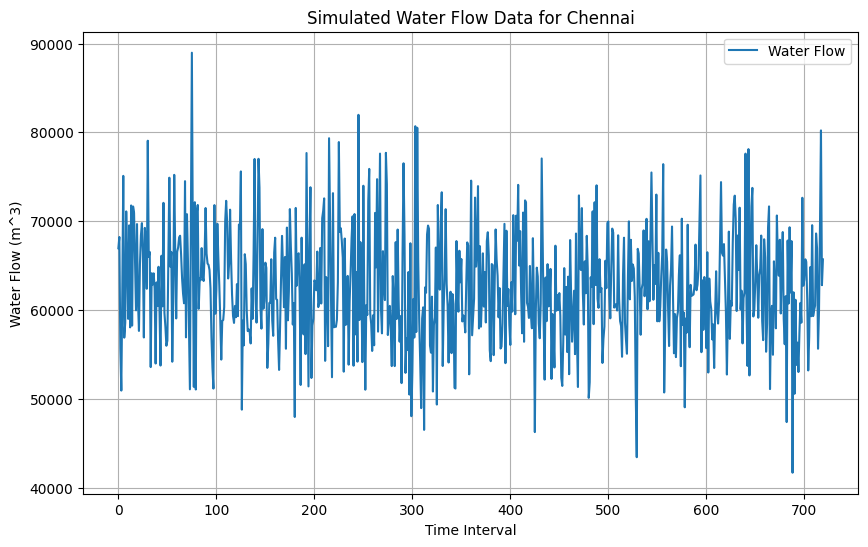

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters (to be adjusted based on assumptions)
population = 10000000  # Estimated population of Chennai
average_demand_per_capita = 150  # Liters per capita per day
num_days = 30  # Number of days to simulate
num_intervals_per_day = 24  # Number of time intervals per day (e.g., hourly)
leak_rate = 0.02  # Assumed leakage rate (2% of total flow)

# Simulate water demand
demand_per_interval = (population * average_demand_per_capita) / (num_intervals_per_day * 1000)  # Convert to cubic meters
water_demand = np.random.normal(loc=demand_per_interval, scale=0.1*demand_per_interval, size=num_days * num_intervals_per_day)

# Simulate leaks
leak_indices = np.random.choice(num_days * num_intervals_per_day, size=int(num_days * num_intervals_per_day * leak_rate), replace=False)
leak_magnitude = np.random.normal(loc=0.2*demand_per_interval, scale=0.05*demand_per_interval, size=len(leak_indices))
leak_data = np.zeros(num_days * num_intervals_per_day)
leak_data[leak_indices] = leak_magnitude

# Simulate water flow with leaks
water_flow_with_leaks = water_demand + leak_data

# Plot simulated data
plt.figure(figsize=(10, 6))
plt.plot(water_flow_with_leaks, label='Water Flow')
plt.xlabel('Time Interval')
plt.ylabel('Water Flow (m^3)')
plt.title('Simulated Water Flow Data for Chennai')
plt.legend()
plt.grid(True)
plt.show()


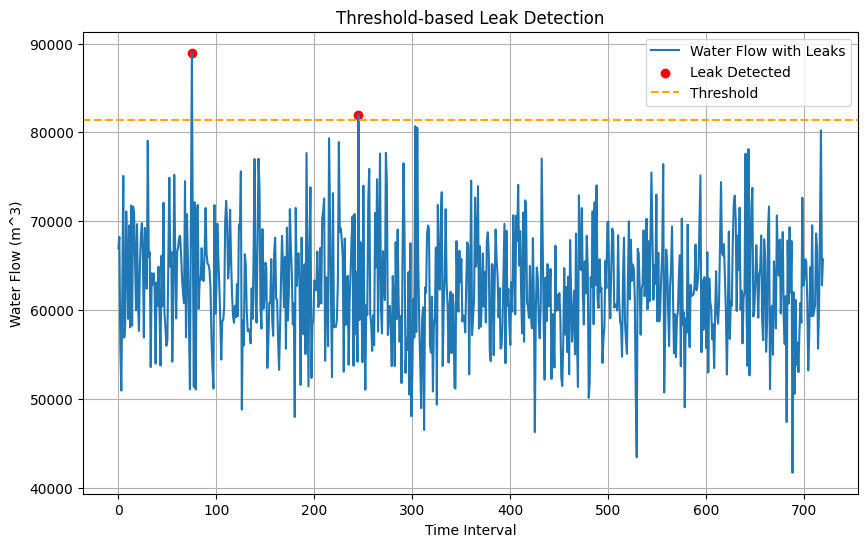

In [9]:
# Parameters (to be adjusted based on data characteristics)
threshold_factor = 1.3  # Adjust this factor to set the threshold
threshold = np.mean(water_flow_with_leaks) * threshold_factor  # Set threshold based on average flow rate

# Detect leaks using threshold-based method
leak_detected = np.where(water_flow_with_leaks > threshold, 1, 0)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(water_flow_with_leaks, label='Water Flow with Leaks')
plt.scatter(np.where(leak_detected == 1)[0], water_flow_with_leaks[leak_detected == 1], color='red', label='Leak Detected')
plt.axhline(y=threshold, color='orange', linestyle='--', label='Threshold')
plt.xlabel('Time Interval')
plt.ylabel('Water Flow (m^3)')
plt.title('Threshold-based Leak Detection')
plt.legend()
plt.grid(True)
plt.show()


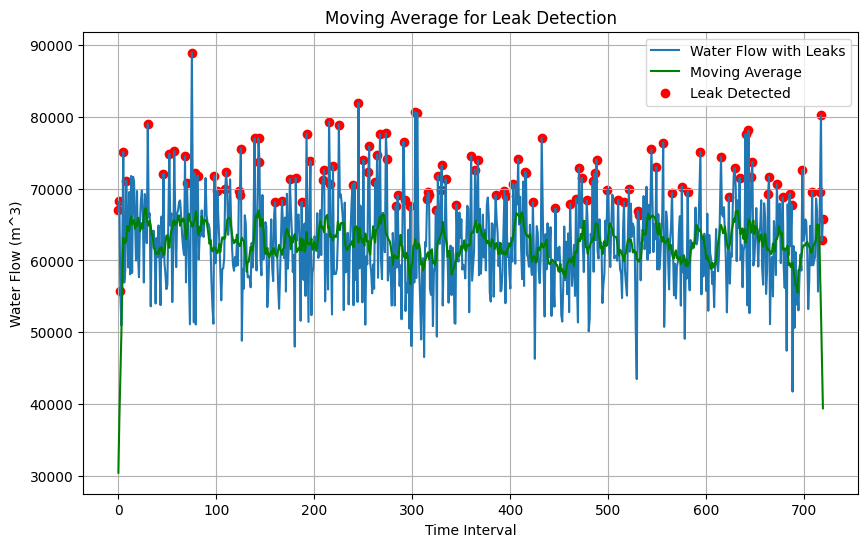

In [10]:

# Parameters (to be adjusted based on data characteristics)
window_size = 10  # Size of the moving average window

# Calculate moving average
moving_avg = np.convolve(water_flow_with_leaks, np.ones(window_size)/window_size, mode='same')

# Detect leaks using moving average
leak_detected_ma = np.where(water_flow_with_leaks - moving_avg > 0.1*np.mean(water_flow_with_leaks), 1, 0)  # Adjust threshold as needed

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(water_flow_with_leaks, label='Water Flow with Leaks')
plt.plot(moving_avg, color='green', label='Moving Average')
plt.scatter(np.where(leak_detected_ma == 1)[0], water_flow_with_leaks[leak_detected_ma == 1], color='red', label='Leak Detected')
plt.xlabel('Time Interval')
plt.ylabel('Water Flow (m^3)')
plt.title('Moving Average for Leak Detection')
plt.legend()
plt.grid(True)
plt.show()


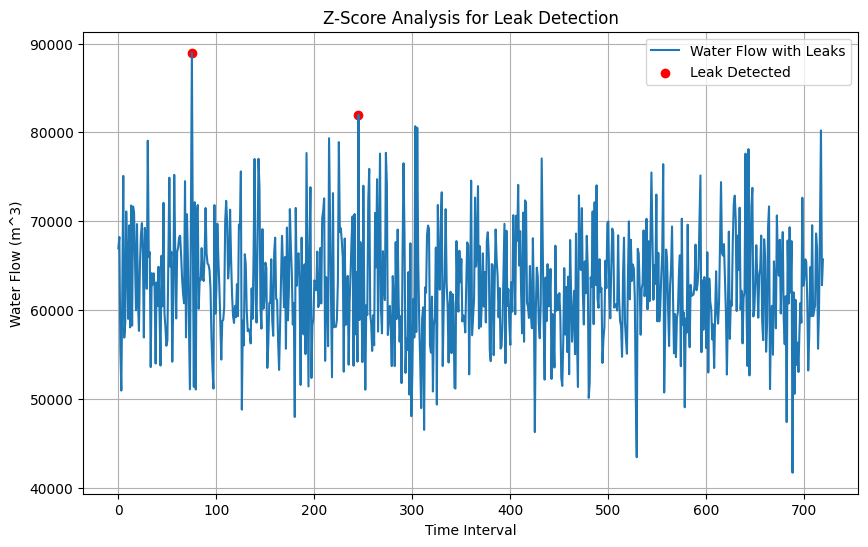

In [11]:
# Parameters (to be adjusted based on data characteristics)
threshold_zscore = 3  # Threshold for z-score (adjust as needed)

# Calculate z-scores
mean_flow = np.mean(water_flow_with_leaks)
std_flow = np.std(water_flow_with_leaks)
z_scores = (water_flow_with_leaks - mean_flow) / std_flow

# Detect leaks using z-scores
leak_detected_zscore = np.where(z_scores > threshold_zscore, 1, 0)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(water_flow_with_leaks, label='Water Flow with Leaks')
plt.scatter(np.where(leak_detected_zscore == 1)[0], water_flow_with_leaks[leak_detected_zscore == 1], color='red', label='Leak Detected')
plt.xlabel('Time Interval')
plt.ylabel('Water Flow (m^3)')
plt.title('Z-Score Analysis for Leak Detection')
plt.legend()
plt.grid(True)
plt.show()


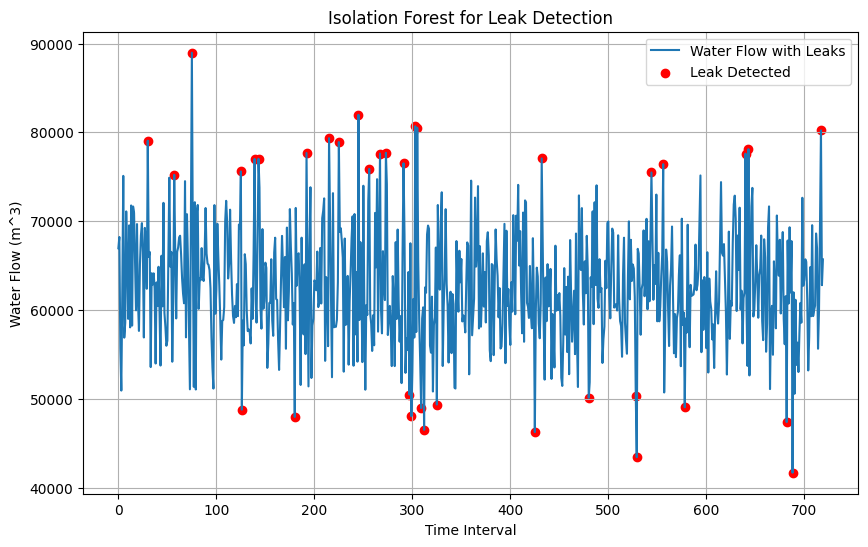

In [12]:
from sklearn.ensemble import IsolationForest

# Reshape the data for compatibility with sklearn
water_flow_with_leaks = water_flow_with_leaks.reshape(-1, 1)

# Parameters
contamination = 0.05  # Proportion of outliers (adjust as needed)

# Fit Isolation Forest model
clf = IsolationForest(contamination=contamination, random_state=42)
clf.fit(water_flow_with_leaks)

# Predict outliers (leaks)
leak_detected_if = clf.predict(water_flow_with_leaks)
leak_detected_if = np.where(leak_detected_if == -1, 1, 0)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(water_flow_with_leaks, label='Water Flow with Leaks')
plt.scatter(np.where(leak_detected_if == 1)[0], water_flow_with_leaks[leak_detected_if == 1], color='red', label='Leak Detected')
plt.xlabel('Time Interval')
plt.ylabel('Water Flow (m^3)')
plt.title('Isolation Forest for Leak Detection')
plt.legend()
plt.grid(True)
plt.show()


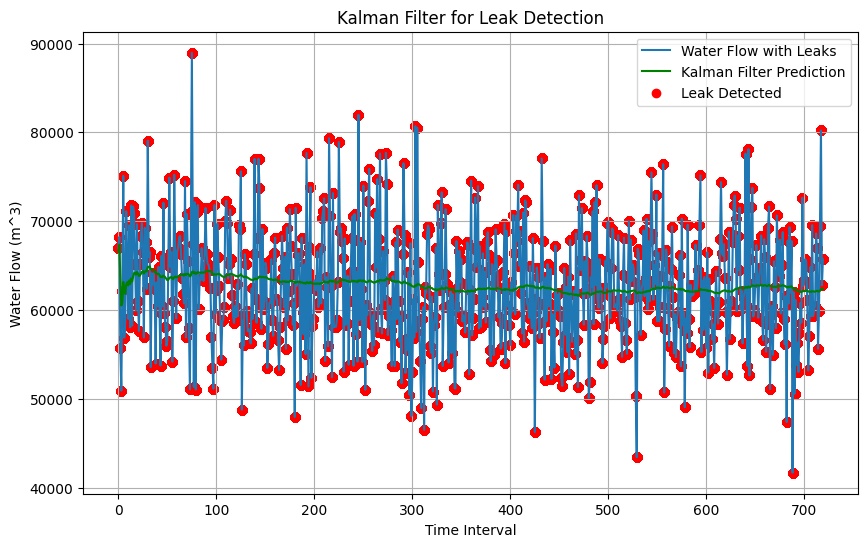

In [15]:

# Parameters
process_variance = 1e-5  # Process variance (adjust as needed)
measurement_variance = 0.1  # Measurement variance (adjust as needed)

# Kalman Filter initialization
x_hat = np.mean(water_flow_with_leaks)  # Initial state estimate
P = 1  # Initial estimation error covariance
A = 1  # State transition matrix
H = 1  # Measurement matrix
Q = process_variance  # Process noise covariance
R = measurement_variance  # Measurement noise covariance

# Lists to store results
x_hat_list = []
P_list = []

# Kalman Filter algorithm
for z in water_flow_with_leaks:
    # Prediction
    x_hat_minus = A * x_hat
    P_minus = A * P * A + Q
    
    # Update
    K = P_minus * H / (H * P_minus * H + R)
    x_hat = x_hat_minus + K * (z - H * x_hat_minus)
    P = (1 - K * H) * P_minus
    
    # Store results
    x_hat_list.append(x_hat)
    P_list.append(P)

# Detect leaks based on deviation from predicted values
leak_detected_kalman = np.where(np.abs(water_flow_with_leaks - x_hat_list) > 3*np.sqrt(P_list), 1, 0)

# Get indices of detected leaks
leak_indices = np.where(leak_detected_kalman == 1)[0]

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(water_flow_with_leaks, label='Water Flow with Leaks')
plt.plot(x_hat_list, color='green', label='Kalman Filter Prediction')
plt.scatter(leak_indices, water_flow_with_leaks[leak_indices], color='red', label='Leak Detected')
plt.xlabel('Time Interval')
plt.ylabel('Water Flow (m^3)')
plt.title('Kalman Filter for Leak Detection')
plt.legend()
plt.grid(True)
plt.show()


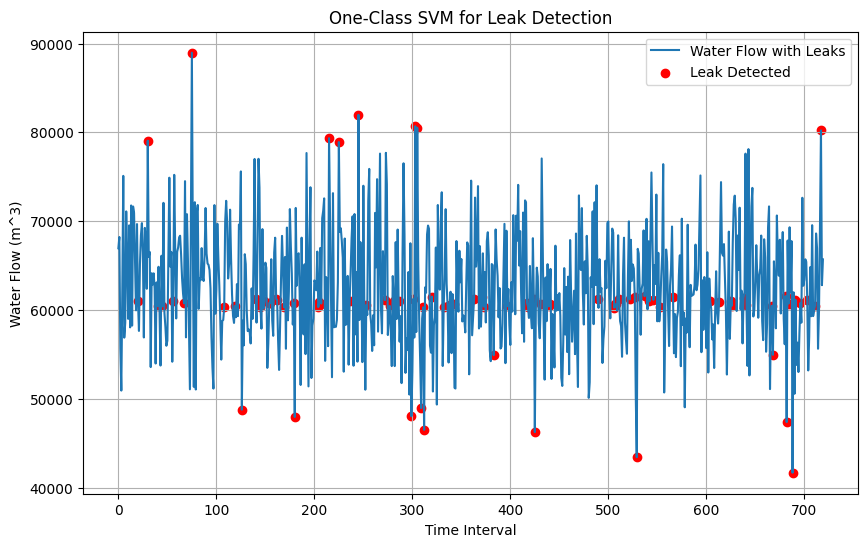

In [16]:
from sklearn.svm import OneClassSVM

# Reshape the data for compatibility with sklearn
water_flow_with_leaks = water_flow_with_leaks.reshape(-1, 1)

# Parameters
nu = 0.05  # Nu parameter (proportion of outliers, adjust as needed)
gamma = 'scale'  # Kernel coefficient (adjust as needed)

# Fit OCSVM model
clf = OneClassSVM(nu=nu, kernel='rbf', gamma=gamma)
clf.fit(water_flow_with_leaks)

# Predict outliers (leaks)
leak_detected_ocsvm = clf.predict(water_flow_with_leaks)
leak_detected_ocsvm = np.where(leak_detected_ocsvm == -1, 1, 0)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(water_flow_with_leaks, label='Water Flow with Leaks')
plt.scatter(np.where(leak_detected_ocsvm == 1)[0], water_flow_with_leaks[leak_detected_ocsvm == 1], color='red', label='Leak Detected')
plt.xlabel('Time Interval')
plt.ylabel('Water Flow (m^3)')
plt.title('One-Class SVM for Leak Detection')
plt.legend()
plt.grid(True)
plt.show()


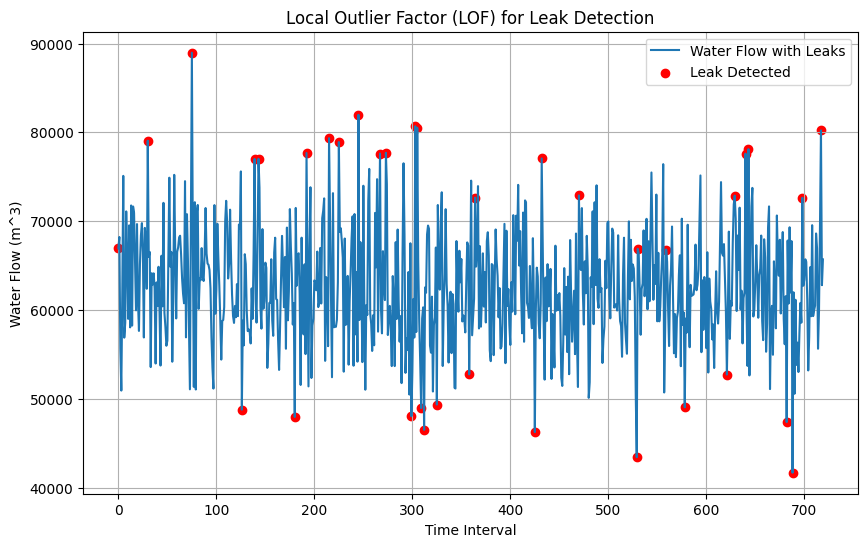

In [17]:
from sklearn.neighbors import LocalOutlierFactor

# Reshape the data for compatibility with sklearn
water_flow_with_leaks = water_flow_with_leaks.reshape(-1, 1)

# Parameters
contamination = 0.05  # Proportion of outliers (adjust as needed)

# Fit LOF model
clf = LocalOutlierFactor(n_neighbors=20, contamination=contamination)
leak_detected_lof = clf.fit_predict(water_flow_with_leaks)

# Convert predictions to binary labels (1 for outliers, 0 for inliers)
leak_detected_lof = np.where(leak_detected_lof == -1, 1, 0)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(water_flow_with_leaks, label='Water Flow with Leaks')
plt.scatter(np.where(leak_detected_lof == 1)[0], water_flow_with_leaks[leak_detected_lof == 1], color='red', label='Leak Detected')
plt.xlabel('Time Interval')
plt.ylabel('Water Flow (m^3)')
plt.title('Local Outlier Factor (LOF) for Leak Detection')
plt.legend()
plt.grid(True)
plt.show()
